## Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [3]:
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
sns.set(style='darkgrid')

In [4]:
from tqdm import tqdm

In [5]:
import tensorflow as tf

## Read data & preprocessing

In [6]:
# read training data
df_X = pd.read_csv('./data/X_train.csv')
df_y = pd.read_csv('./data/y_train.csv')

In [7]:
# convert into np array, check shape
X_raw = np.array(df_X)[:, 1:]
print(X_raw.shape)

y_raw = np.array(df_y, dtype=int)[:, 1]
print(y_raw.shape)

num_samples = X_raw.shape[0]
num_features = X_raw.shape[1]

(5117, 17813)
(5117,)


In [8]:
# data frames no longer needed
del df_X, df_y

In [9]:
# shuffle the dataset
X_raw, y_raw = shuffle(X_raw, y_raw)

In [10]:
# recordings trimmed of NaNs
recordings = []
for i in range(X_raw.shape[0]):
    recordings.append(X_raw[i, ~np.isnan(X_raw[i,:])])

print(recordings[0])

[-26. -25. -15. ... 132. 129. 126.]


In [11]:
# dataset augmented by repetition
def augmentation(X, subsampling=1, normalize=False, mirror=False):
    augmented = np.copy(X)
    for i in tqdm(range(X.shape[0])):
        n = 17813
        for j in range(X.shape[1]):
            if np.isnan(X[i,j]):
                n = j
                break
        for j in range(n, X.shape[1]):
            if mirror: 
                augmented[i,j] = augmented[i, j - 2*(j%n) - 1]
            else:
                augmented[i,j] = augmented[i, j%n]
        if normalize:
            augmented[i,:] = scale(augmented[i,:])
        
    return augmented[:,::subsampling]

In [ ]:
X_augmented = augmentation(X_raw, subsampling=4, normalize=True)

# make sure no more NaN exists
np.sum(np.isnan(X_augmented))

In [ ]:
X_augmented.shape

In [ ]:
X_train = X_augmented[0:5000, :]
X_validation = X_augmented[5000:, :]
y_train = y_raw[0:5000]
y_validation = y_raw[5000:]

In [ ]:
# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

In [ ]:
# dynamic time warpping -- too slow to be used
def constrained_dtw(t1, t2, w=float('inf'), matrix=False):
    n1 = len(t1)
    n2 = len(t2)
    if w < abs(n1 - n2):
        print('ERROR: constraint smaller than difference in length.')
        exit(1)
    
    # distance matrix with infinity for all entries
    dist_matrix = np.ones((n1+1, n2+1)) * float('inf')
    dist_matrix[0,0] = 0
    
    # distance within the contrained range
    for i in range(n1):
        for j in range(n2): 
            if abs(i-j) <= w:
                dist_matrix[i+1,j+1] = abs(t1[i] - t2[j]) + min(dist_matrix[i,j], dist_matrix[i+1,j], dist_matrix[i,j+1])
    
    if matrix: 
        return dist_matrix
    else:
        return dist_matrix[n1,n2]

In [ ]:
a = np.array([np.sin(x*0.5) for x in range(100)])
#plt.plot(a)
plt.plot(np.fft.rfft(a))

In [ ]:
y_raw[0:20]

In [ ]:
n1 = 103

print('class:', y_raw[n1])
print('mean:', np.mean(recordings[n1]))
print('variance:', np.var(recordings[n1]))

plt.figure(figsize=(16,8))
plt.plot(recordings[n1])
plt.show()

plt.figure(figsize=(16,8))
plt.plot(filtered[n1])
plt.show()

## Feature Extraction

In [12]:
from biosppy.signals import ecg

In [13]:
ecgs = [ecg.ecg(signal=r, sampling_rate=300, show=False) for r in tqdm(recordings)]

100%|██████████| 5117/5117 [03:26<00:00, 24.72it/s]


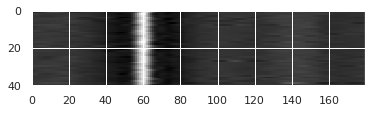

In [14]:
plt.imshow(ecgs[0]['templates'], cmap='gray')

class: 0
mean: -2.4928848641655885
variance: 27719.702083915596
0.16225845347990406
0.07682325613043073


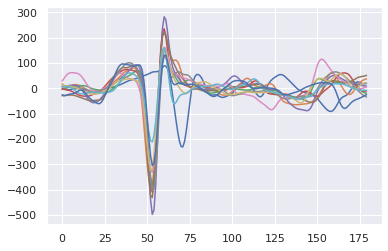

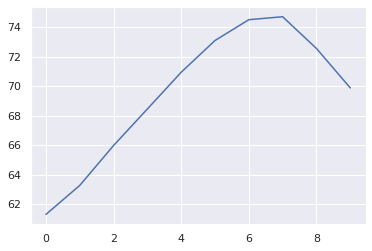

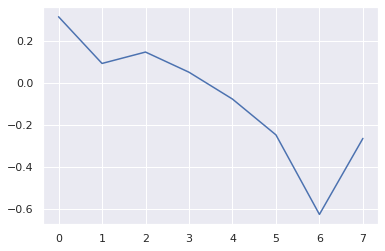

In [15]:
n1 = 5

hr_first_derivative = scale(ecgs[n1]['heart_rate'][1:]) - scale(ecgs[n1]['heart_rate'][:-1])
hr_second_derivative = hr_first_derivative[1:] - hr_first_derivative[:-1]

print('class:', y_raw[n1])
print('mean:', np.mean(recordings[n1]))
print('variance:', np.var(recordings[n1]))
print(np.var(hr_first_derivative))
print(np.var(hr_second_derivative))

for i in ecgs[n1]['templates']:
    plt.plot(i)
plt.show()

plt.plot(ecgs[n1]['heart_rate'])
plt.show()

plt.plot(hr_second_derivative)
plt.show()

In [16]:
filtered = np.ones((len(ecgs), 17813)) * np.nan
for i in range(len(ecgs)):
    filtered[i,:len(ecgs[i]['filtered'])] = ecgs[i]['filtered']

np.sum(np.isnan(filtered))

44866481

In [17]:
augmented_filtered = augmentation(filtered, subsampling=1, normalize=True, mirror=False)
np.sum(np.isnan(augmented_filtered))

100%|██████████| 5117/5117 [01:08<00:00, 74.74it/s]


0

In [18]:
ecgs[0].keys()

['ts',
 'filtered',
 'rpeaks',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate']

In [19]:
from scipy.stats import median_absolute_deviation

def feature_extraction(sample):
    features = []
    
    # r peak features
    r_amplitudes = sample['filtered'][sample['rpeaks']] # amplitudes at extracted R peaks
    features.append(np.mean(r_amplitudes)) # mean R peak amplitude
    features.append(np.median(r_amplitudes)) # median R peak amplitude
    features.append(np.var(r_amplitudes)) # variance of R peak amplitudes
    
    # heart rate features
    if len(sample['heart_rate']) == 0:
        hr_scaled = np.array([0.])
    else:
        hr_scaled = scale(sample['heart_rate'])
    hr_first_derivative = hr_scaled[1:] - hr_scaled[:-1]
    hr_second_derivative = hr_first_derivative[1:] - hr_first_derivative[:-1]
    features.append(np.var(hr_first_derivative)) # variance of first derivative of normalized heart rates
    features.append(np.var(hr_second_derivative)) # variance of second derivative of normalized heart rates
    features.append(np.mean(sample['heart_rate'])) # mean heart rate
    features.append(np.median(sample['heart_rate'])) # median heart rate
    features.append(np.var(sample['heart_rate'])) # variance of heart rates
    
    # RR interval features
    rr_first_derivative = sample['rpeaks'][1:] - sample['rpeaks'][:-1]
    rr_second_derivative = rr_first_derivative[1:] - rr_first_derivative[:-1]
    features.append(np.std(rr_first_derivative)) # standard deviation of RR intervals
    features.append(np.std(rr_second_derivative)) # standard deviation of intervals of RR intervals
    features.append(np.sqrt(np.mean(np.square(rr_second_derivative)))) # RMSSD
    features.append(np.sum(np.absolute(j/300*1000)>50 for j in rr_second_derivative)) # NN50
    features.append(np.sum(np.absolute(j/300*1000)>20 for j in rr_second_derivative)) # NN20
    features.append(np.var([1000/j for j in rr_first_derivative])) # HRV
    
    # template features
    templates = sample['templates']
    templates_scaled = scale(templates)
    template_first_derivative = templates_scaled[:,1:] - templates_scaled[:,:-1]
    template_second_derivative = template_first_derivative[:,1:] - template_first_derivative[:,:-1]
    means = np.mean(templates, axis=0) # mean template values
    medians = np.median(templates, axis=0) # median template values
    variances = np.var(templates, axis=0) # variances of templates
    maxima = np.max(templates_scaled, axis=0) # greatest values (unit = standard deviation)
    minima = np.min(templates_scaled, axis=0) # least values (unit = standard deviation)
    mad = median_absolute_deviation(templates, axis=0) # median absolute deviation
    
    features.append(np.mean(means)) # mean of means
    features.append(np.var(means)) # variance of means
    features.append(np.mean(variances)) # mean of variances
    features.append(np.var(variances)) # variance of variances
    features.append(np.mean(medians)) # mean of medians
    features.append(np.var(medians)) # variance of medians
    features.append(np.mean(mad)) # mean of MADs
    features.append(np.var(mad)) # variance of MADs
    features.append(np.mean(maxima)) # mean maximum
    features.append(np.mean(minima)) # mean minimum
    features.append(np.var(maxima)) # variance of maxima
    features.append(np.var(minima)) # variance of minima
    # variance of means of first derivatives of templates
    features.append(np.var(np.mean(template_first_derivative, axis=0))) 
    # variance of means of second derivatives of templates
    features.append(np.var(np.mean(template_second_derivative, axis=0)))
    
    return np.array(features)

In [ ]:
rpeaks = ecg.hamilton_segmenter(signal=recordings[0], sampling_rate=300)[0]
rpeaks

In [ ]:
X_features = np.array([feature_extraction(x) for x in tqdm(recordings)])

In [ ]:
plt.figure(figsize=(16,8))
sns.scatterplot(X_features[:,2], X_features[:,3], hue=y_raw)

In [ ]:
clf = SVC(gamma='auto', kernel='rbf', class_weight='balanced')
s = cross_val_score(clf, X_features, y_raw, cv=10, scoring='balanced_accuracy')
print(s)

In [ ]:
# find least and greatest number of peaks
least = ecgs[0]['templates'].shape[0]
least_id = 0
most = ecgs[0]['templates'].shape[0]
most_id = 0

for i in range(1,len(ecgs)):
    if ecgs[i]['templates'].shape[0] < least:
        least = ecgs[i]['templates'].shape[0]
        least_id = i
    if ecgs[i]['templates'].shape[0] > most:
        most = ecgs[i]['templates'].shape[0]
        most_id = i

print(least_id)
print(least)
print(most_id)
print(most)

In [ ]:
idx = 110
neighbourhood = 256
subsampling = 1
a = []
b = []
for r in peaks[idx]:
    normalized = scale(recordings[idx])
    if r > neighbourhood and r < len(recordings[idx]) - neighbourhood:
        a.append(recordings[idx][r - neighbourhood : r + neighbourhood : subsampling])
        b.append(normalized[r - neighbourhood : r + neighbourhood : subsampling])

c = np.mean(np.array(a), axis=0)
d = [np.abs(a[i] - a[i-1]) for i in range(1,len(a))]
d = np.mean(np.array(d), axis=0)
e = np.mean(np.array(b), axis=0)
f = [np.abs(b[i] - b[i-1]) for i in range(1,len(b))]
f = np.mean(np.array(f), axis=0)
print('class:', y_raw[idx])
plt.plot(d)
plt.show()
plt.plot(f)
plt.show()

In [ ]:
# augmentation
subsampling = 2
X_2d = np.zeros((len(ecgs), most, 180 // subsampling))
for i in tqdm(range(len(ecgs))):
    n = ecgs[i]['templates'].shape[0]
    X_2d[i,0:n,:] = ecgs[i]['templates'][:,::subsampling]
    for j in range(n, most):
        X_2d[i,j,:] = X_2d[i,j-2*(j%n)-1,:]

In [ ]:
ecgs[1]['templates'].shape[0]

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(X_2d[1], cmap='gray')

## SVM

In [20]:
features = np.array([feature_extraction(sample) for sample in tqdm(ecgs)])

  0%|          | 0/5117 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum b

  1%|          | 46/5117 [00:00<00:11, 455.39it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the py

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  2%|▏         | 93/5117 [00:00<00:10, 457.11it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the py

  3%|▎         | 142/5117 [00:00<00:10, 464.12it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  4%|▎         | 191/5117 [00:00<00:10, 469.10it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  5%|▍         | 241/5117 [00:00<00:10, 474.05it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  6%|▌         | 289/5117 [00:00<00:10, 475.00it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  7%|▋         | 338/5117 [00:00<00:09, 478.99it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

  8%|▊         | 386/5117 [00:00<00:09, 479.27it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

  8%|▊         | 434/5117 [00:00<00:09, 478.13it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  9%|▉         | 483/5117 [00:01<00:09, 478.91it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 10%|█         | 530/5117 [00:01<00:09, 473.71it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 30%|██▉       | 1528/5117 [00:03<00:08, 433.52it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 32%|███▏      | 1620/5117 [00:03<00:07, 442.68it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 33%|███▎      | 1665/5117 [00:03<00:07, 439.12it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 34%|███▍      | 1752/5117 [00:03<00:08, 415.38it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 35%|███▌      | 1794/5117 [00:04<00:07, 416.58it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 37%|███▋      | 1881/51

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 47%|████▋     | 2409/5117 [00:05<00:06, 438.29it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 49%|████▉     | 2500/5117 [00:05<00:05, 443.69it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 51%|█████     | 2590/5117 [00:05<00:05, 443.59it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 53%|█████▎    | 2727/5117 [00:06<00:05, 444.43it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 56%|█████▌    | 2863/5117 [00:06<00:05, 441.95it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 60%|██████    | 3090/5117 [00:06<00:04, 446.51it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 67%|██████▋   | 3453/5117 [00:07<00:03, 433.92it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 70%|███████   | 3585/5117 [00:08<00:03, 426.95it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 72%|███████▏  | 3674/5117 [00:08<00:03, 432.56it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 74%|███████▎  | 3767/5117 [00:08<00:03, 446.84it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 76%|███████▋  | 3902/51

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 82%|████████▏ | 4172/51

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 84%|████████▍ | 4307/5117 [00:09<00:01, 414.42it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

 87%|████████▋ | 4439/5117 [00:10<00:01, 432.19it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 92%|█████████▏| 4700/51

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
 99%|█████████▉| 5061/51

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7

100%|██████████| 5117/5117 [00:11<00:00, 439.20it/s]


In [21]:
features[np.isnan(features)] = 0
np.sum(np.isnan(features))

0

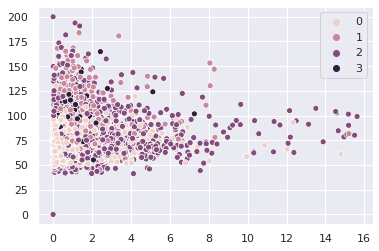

In [30]:
sns.scatterplot(features[:,4], features[:,5], hue=y_raw)

In [ ]:
# OvO approach
clf = [SVC(gamma='auto', kernel='linear', class_weight='balanced') for i in range(6)]

features_ovo = [
    features[y_raw == 0 or y_raw == 1]
    features[y_raw == 0 or y_raw == 2]
    features[y_raw == 0 or y_raw == 3]
    features[y_raw == 1 or y_raw == 2]
    features[y_raw == 1 or y_raw == 3]
    features[y_raw == 2 or y_raw == 3]
]

y_ovo = [
    y_raw[y_raw == 0 or y_raw == 1]
    y_raw[y_raw == 0 or y_raw == 2]
    y_raw[y_raw == 0 or y_raw == 3]
    y_raw[y_raw == 1 or y_raw == 2]
    y_raw[y_raw == 1 or y_raw == 3]
    y_raw[y_raw == 2 or y_raw == 3]
]

In [ ]:
for i in range(6):
    clf[i].fit(features[i])

In [ ]:
def ovo_predict(clf, test_features):
    labels = []
    labels.append(clf[0], test_features)
    labels.append(clf[1], test_features)
    labels.append(clf[2], test_features)
    labels.append(clf[3], test_features)
    labels.append(clf[4], test_features)
    labels.append(clf[5], test_features)
    labels = np.arrray(labels)
    highest = 0
    pred = 0
    for i in range(4):
        if np.sum(labels == i) > highest:
            highest = np.sum(labels == i)
            pred = i
    return pred

In [ ]:
clf = SVC(gamma='auto', kernel='linear', class_weight='balanced')

In [ ]:
clf.fit(features[:5000], y_raw[:5000])

In [ ]:
y_true = y_raw[5000:]
y_pred = clf.predict(features[5000:])

In [ ]:
np.sum(clf.predict(features[:5000]) == y_raw[:5000])

In [ ]:
f1_score(y_true, y_pred)

In [ ]:
feature_nn = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(28,)),
        
        tf.keras.layers.Dense(16, activation='relu'),
        
        tf.keras.layers.Dense(8, activation='relu'),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

feature_nn.compile(optimizer='adam', loss='mse', metrics=['accuracy',f1_score])
feature_nn.summary()

In [ ]:
split = 4800
X_train = features[:split]
X_validation = features[split:]
y_train = y_raw[:split]
y_validation = y_raw[split:]

y_target = tf.keras.utils.to_categorical(y_train)
validation_dataset = (X_validation, tf.keras.utils.to_categorical(y_validation))

# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

In [ ]:
history = feature_nn.fit(x=X_train,
                    y=y_target,
                    batch_size=32,
                    epochs=8,
                    validation_data=validation_dataset)

## Data split for neural network

In [36]:
split = 4800
X_train = augmented_filtered[:split]
X_validation = augmented_filtered[split:]
y_train = y_raw[:split]
y_validation = y_raw[split:]

y_target = tf.keras.utils.to_categorical(y_train)
validation_dataset = (X_validation, tf.keras.utils.to_categorical(y_validation))

# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

2858 414 1371 157
172 29 103 13


## Autoencoder

In [ ]:
# 1 dimensional CNN for augmented data
autoencoder = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(17813,), target_shape=(17183,1)),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=8, padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
        
        tf.keras.layers.Dense(64, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=8, padding='same'),
        tf.keras.layers.UpSampling1D(2),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same'),
        tf.keras.layers.UpSampling1D(2),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=1, activation='sigmoid', padding='same'),
        
        tf.keras.layers.Reshape(target_shape=(17183,)),
    ]
)

autoencoder.compile(optimizer='adadelta', loss='mse', metrics=[])
autoencoder.summary()

In [ ]:
X_train.shape

In [ ]:
history = autoencoder.fit(x=X_train,
                          y=X_train,
                          batch_size=32, 
                          epochs=10,
                          validation_data=(X_validation, X_validation)) 

## CNN for 1D data

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [37]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    c2 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    c3 = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    # if c3 == 0:
    #     return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [39]:
# 1 dimensional CNN for augmented data
model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(17813,), target_shape=(17813, 1)),
        
        tf.keras.layers.Conv1D(kernel_size=11, filters=16, strides=2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv1D(kernel_size=11, filters=16, strides=2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool1D(pool_size=(2,), strides=(2,)),
        
        tf.keras.layers.Conv1D(kernel_size=7, filters=32, strides=2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv1D(kernel_size=7, filters=32, strides=2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool1D(pool_size=(2,), strides=(2,)),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.GlobalMaxPooling1D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(4, activation='softmax'),
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 17813, 1)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 8902, 16)          192       
_________________________________________________________________
batch_normalization_6 (Batch (None, 8902, 16)          64        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 4446, 16)          2832      
_________________________________________________________________
batch_normalization_7 (Batch (None, 4446, 16)          64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2223, 16)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1109, 32)         

In [ ]:
y_target.shape

In [40]:
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
mcp = tf.keras.callbacks.ModelCheckpoint('./best_1d_model.hdf5', monitor='val_f1_score', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
history = model.fit(x=X_train,
                    y=y_target,
                    batch_size=32,
                    epochs=24,
                    validation_data=validation_dataset,
                    callbacks=[mcp])

Train on 4800 samples, validate on 317 samples
Epoch 1/24
4800/4800 [==============================] - 20s 4ms/sample - loss: 1.1371 - accuracy: 0.5808 - f1_score: 0.5541 - val_loss: 1.2081 - val_accuracy: 0.3596 - val_f1_score: nan
Epoch 2/24
4800/4800 [==============================] - 18s 4ms/sample - loss: 0.7636 - accuracy: 0.6875 - f1_score: 0.6704 - val_loss: 0.8710 - val_accuracy: 0.5804 - val_f1_score: 0.5447
Epoch 3/24
4800/4800 [==============================] - 18s 4ms/sample - loss: 0.6726 - accuracy: 0.7267 - f1_score: 0.7153 - val_loss: 0.6385 - val_accuracy: 0.7224 - val_f1_score: 0.7139
Epoch 4/24
4800/4800 [==============================] - 18s 4ms/sample - loss: 0.5930 - accuracy: 0.7579 - f1_score: 0.7513 - val_loss: 0.6400 - val_accuracy: 0.7319 - val_f1_score: 0.7223
Epoch 5/24
4800/4800 [==============================] - 18s 4ms/sample - loss: 0.5628 - accuracy: 0.7698 - f1_score: 0.7603 - val_loss: 0.6472 - val_accuracy: 0.7382 - val_f1_score: 0.7349
Epoch 6/24


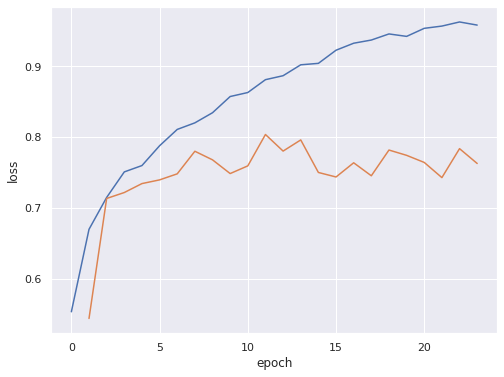

In [41]:
plt.figure(figsize=(8,6))
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## CNN for 2D data

In [ ]:
# 1 dimensional CNN for 2D data
model_1d = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(most, 180//subsampling)),
        
        tf.keras.layers.Conv1D(kernel_size=11, filters=64, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=11, filters=64, activation='relu'),
        
        tf.keras.layers.Conv1D(kernel_size=11, filters=128, activation='relu'),
        
        tf.keras.layers.GlobalMaxPooling1D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model_1d.summary()

In [ ]:
# 2 dimensional CNN
model_2d = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(most, 180//subsampling), target_shape=(most, 180//subsampling, 1)),
        
        tf.keras.layers.Conv2D(kernel_size=11, filters=16, activation='elu'),
        
        tf.keras.layers.Conv2D(kernel_size=11, filters=16, activation='elu'),
        
        tf.keras.layers.Conv2D(kernel_size=11, filters=16, activation='elu'),
        
        tf.keras.layers.GlobalMaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model_2d.summary()

In [ ]:
# model from google
model_2d = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape(input_shape=(most, 180//subsampling), target_shape=(most, 180//subsampling, 1)),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, strides = (1,1), kernel_initializer='glorot_uniform'),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(512),
        tf.keras.layers.ELU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ]
)

model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
model_2d.summary()


In [ ]:
X_2d.shape

In [ ]:
split = 5090
X_train = X_2d[:split]
X_validation = X_2d[split:]
y_train = y_raw[:split]
y_validation = y_raw[split:]

y_target = tf.keras.utils.to_categorical(y_train)
validation_dataset = (X_validation, tf.keras.utils.to_categorical(y_validation))

# check group balance
print(np.sum(y_train == 0), np.sum(y_train == 1), np.sum(y_train == 2), np.sum(y_train == 3))
print(np.sum(y_validation == 0), np.sum(y_validation == 1), np.sum(y_validation == 2), np.sum(y_validation == 3))

In [ ]:
model = model_2d
model.fit(x=X_train,
          y=y_target,
          batch_size=32, 
          epochs=1, 
          validation_data=validation_dataset)

## Predict

In [42]:
df_test = pd.read_csv('./data/X_test.csv')
X_test = np.array(df_test)[:,1:]
X_test.shape

(3411, 17813)

In [43]:
del df_test

In [44]:
X_test.shape[0]

3411

In [47]:
test_recordings = []
for i in range(X_test.shape[0]):
    test_recordings.append(X_test[i, ~np.isnan(X_test[i,:])])

test_ecgs = [ecg.ecg(signal=r, sampling_rate=300, show=False) for r in test_recordings]

  3%|▎         | 90/3411 [00:15<02:16, 24.29it/s]

In [48]:
test_filtered = np.ones((len(test_ecgs), 17813)) * np.nan
for i in range(len(test_ecgs)):
    test_filtered[i,:len(test_ecgs[i]['filtered'])] = test_ecgs[i]['filtered']

np.sum(np.isnan(test_filtered))

30015432

In [50]:
test_augmented = augmentation(test_filtered, subsampling=1, normalize=True, mirror=False)
np.sum(np.isnan(test_augmented))



  0%|          | 0/3411 [00:00<?, ?it/s]

  0%|          | 8/3411 [00:00<00:45, 74.34it/s]

  0%|          | 16/3411 [00:00<00:45, 74.01it/s]

  1%|          | 24/3411 [00:00<00:45, 74.52it/s]

  1%|          | 32/3411 [00:00<00:44, 75.58it/s]

  1%|          | 39/3411 [00:00<00:45, 73.42it/s]

  1%|▏         | 47/3411 [00:00<00:45, 73.83it/s]

  2%|▏         | 55/3411 [00:00<00:45, 74.06it/s]

  2%|▏         | 62/3411 [00:00<00:46, 72.33it/s]

  2%|▏         | 69/3411 [00:00<00:48, 69.43it/s]

  2%|▏         | 77/3411 [00:01<00:47, 70.16it/s]

  2%|▏         | 84/3411 [00:01<00:48, 68.41it/s]

  3%|▎         | 93/3411 [00:01<00:46, 71.98it/s]

  3%|▎         | 101/3411 [00:01<00:46, 71.02it/s]

  3%|▎         | 109/3411 [00:01<00:45, 72.05it/s]

  3%|▎         | 117/3411 [00:01<00:45, 72.02it/s]

  4%|▎         | 125/3411 [00:01<00:45, 71.53it/s]

  4%|▍         | 133/3411 [00:01<00:45, 72.71it/s]

  4%|▍         | 141/3411 [00:01<00:45, 72.44it/s]

  4%|▍         | 149/3411 [00:02<

 32%|███▏      | 1083/3411 [00:15<00:33, 68.60it/s]

 32%|███▏      | 1091/3411 [00:15<00:33, 70.09it/s]

 32%|███▏      | 1099/3411 [00:15<00:32, 72.11it/s]

 32%|███▏      | 1107/3411 [00:15<00:32, 70.12it/s]

 33%|███▎      | 1115/3411 [00:16<00:34, 66.01it/s]

 33%|███▎      | 1123/3411 [00:16<00:33, 68.71it/s]

 33%|███▎      | 1131/3411 [00:16<00:32, 70.77it/s]

 33%|███▎      | 1139/3411 [00:16<00:31, 72.94it/s]

 34%|███▎      | 1147/3411 [00:16<00:30, 73.17it/s]

 34%|███▍      | 1155/3411 [00:16<00:31, 72.28it/s]

 34%|███▍      | 1163/3411 [00:16<00:30, 73.37it/s]

 34%|███▍      | 1171/3411 [00:16<00:31, 71.76it/s]

 35%|███▍      | 1179/3411 [00:16<00:31, 71.59it/s]

 35%|███▍      | 1187/3411 [00:17<00:33, 66.08it/s]

 35%|███▌      | 1194/3411 [00:17<00:34, 64.36it/s]

 35%|███▌      | 1201/3411 [00:17<00:33, 65.65it/s]

 35%|███▌      | 1208/3411 [00:17<00:34, 64.40it/s]

 36%|███▌      | 1215/3411 [00:17<00:34, 64.53it/s]

 36%|███▌      | 1223/3411 [00:17<00:32, 67.13

 63%|██████▎   | 2156/3411 [00:30<00:18, 67.99it/s]

 63%|██████▎   | 2163/3411 [00:31<00:18, 66.22it/s]

 64%|██████▎   | 2170/3411 [00:31<00:19, 63.75it/s]

 64%|██████▍   | 2177/3411 [00:31<00:18, 65.08it/s]

 64%|██████▍   | 2184/3411 [00:31<00:18, 66.24it/s]

 64%|██████▍   | 2192/3411 [00:31<00:18, 67.60it/s]

 64%|██████▍   | 2200/3411 [00:31<00:17, 68.31it/s]

 65%|██████▍   | 2207/3411 [00:31<00:17, 68.41it/s]

 65%|██████▍   | 2215/3411 [00:31<00:17, 69.41it/s]

 65%|██████▌   | 2222/3411 [00:31<00:17, 68.95it/s]

 65%|██████▌   | 2230/3411 [00:32<00:17, 69.31it/s]

 66%|██████▌   | 2237/3411 [00:32<00:17, 67.27it/s]

 66%|██████▌   | 2244/3411 [00:32<00:17, 65.04it/s]

 66%|██████▌   | 2251/3411 [00:32<00:17, 65.98it/s]

 66%|██████▌   | 2258/3411 [00:32<00:17, 66.74it/s]

 66%|██████▋   | 2265/3411 [00:32<00:17, 64.52it/s]

 67%|██████▋   | 2273/3411 [00:32<00:16, 67.25it/s]

 67%|██████▋   | 2281/3411 [00:32<00:16, 69.04it/s]

 67%|██████▋   | 2288/3411 [00:32<00:16, 68.07

 94%|█████████▍| 3206/3411 [00:46<00:03, 67.00it/s]

 94%|█████████▍| 3214/3411 [00:46<00:02, 70.04it/s]

 94%|█████████▍| 3222/3411 [00:46<00:02, 70.85it/s]

 95%|█████████▍| 3230/3411 [00:46<00:02, 71.87it/s]

 95%|█████████▍| 3238/3411 [00:46<00:02, 72.02it/s]

 95%|█████████▌| 3246/3411 [00:46<00:02, 73.59it/s]

 95%|█████████▌| 3254/3411 [00:46<00:02, 73.44it/s]

 96%|█████████▌| 3262/3411 [00:47<00:02, 72.25it/s]

 96%|█████████▌| 3270/3411 [00:47<00:01, 73.87it/s]

 96%|█████████▌| 3278/3411 [00:47<00:01, 69.52it/s]

 96%|█████████▋| 3286/3411 [00:47<00:01, 68.10it/s]

 97%|█████████▋| 3293/3411 [00:47<00:01, 67.95it/s]

 97%|█████████▋| 3300/3411 [00:47<00:01, 67.10it/s]

 97%|█████████▋| 3308/3411 [00:47<00:01, 68.27it/s]

 97%|█████████▋| 3316/3411 [00:47<00:01, 67.48it/s]

 97%|█████████▋| 3324/3411 [00:47<00:01, 69.12it/s]

 98%|█████████▊| 3331/3411 [00:48<00:01, 65.94it/s]

 98%|█████████▊| 3338/3411 [00:48<00:01, 64.12it/s]

 98%|█████████▊| 3346/3411 [00:48<00:00, 67.64

0

In [51]:
model.load_weights('./best_1d_model.hdf5')
y_test = model.predict(test_augmented)
y_test

array([[9.0482616e-01, 1.4392837e-04, 9.4901368e-02, 1.2860024e-04],
       [8.3605766e-01, 9.0982052e-05, 1.6383845e-01, 1.2812190e-05],
       [9.4558257e-01, 8.4262654e-05, 4.8093904e-02, 6.2391874e-03],
       ...,
       [9.7344738e-01, 2.9719142e-05, 2.6498195e-02, 2.4670482e-05],
       [9.9262297e-01, 8.0402981e-07, 7.3758294e-03, 3.1844746e-07],
       [7.6854677e-04, 9.0123975e-01, 9.7956173e-02, 3.5418416e-05]],
      dtype=float32)

In [52]:
result = np.argmax(y_test, axis=1)
result

array([0, 0, 0, ..., 0, 0, 1])

## Output

In [58]:
# write output csv
out_df = pd.DataFrame(data={'y': result})
out_df.to_csv('result14.csv', index_label='id')

In [57]:
# compare with an existing output
old_df = pd.read_csv('result13.csv')
old_pred = np.array(old_df['y'])
np.sum(result != old_pred)

572